In [ ]:
import numpy as np
import scipy.stats as ss
import ipywidgets as wd
import pandas as pd
import yaml
import time
import os
import matplotlib.pyplot as plt
from presets import mid_preset, low_preset, high_preset

In [ ]:
import sys
import logging

# # Take care of some logging
# # Remove all handlers associated with the root logger object.
# for handler in logging.root.handlers[:]:
#     logging.root.removeHandler(handler)
# logging.basicConfig(filename='example.log',level=logging.INFO, filemode='w', format="%(asctime)s [%(name)s - %(threadName)s] [%(levelname)s]  %(message)s", datefmt='%m/%d/%Y %I:%M:%S %p')
# logging.getLogger().addHandler(logging.StreamHandler(sys.stderr))

logPath, fileName = os.getcwd(), 'interface_logger'
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(name)s - %(threadName)s] [%(levelname)s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(logPath, fileName)),
#         logging.StreamHandler()
    ])

logger = logging.getLogger()
logger.info("test")
## Test logger functionality: 
# logging.warning('This is a warning message this should be printed on your console, its level is above the set level')
# logging.info('This is an info message it should be printed now!')
# logging.debug('This is a debug message which will not be shown, its level is below the set level')

In [ ]:
sleeptime = 1  # delay (seconds) between messages.

In [ ]:
def beta_dist(min_value=0, max_value=1, a=1, b=1):
    return ss.beta(loc=min_value, scale=(max_value-min_value), a=a, b=b)

def auto_fill(height='auto', width='auto', label=''):
    return wd.Button(description=label, layout=auto_lay(width,height))

def auto_lay(width='auto', height='auto'):
    return wd.Layout(height=height, width=width)

In [ ]:
def generate_sample_dict(S:dict):
    P = S.dist # take a sample set that has input samples already generated.
    lam = S.samples
    V = {n:{v: None for v in P.vars} for n in P.names}
    for d in range(S.dim):
        p_info = P.params[d].rsplit('-')
        V[p_info[1]][p_info[0]] = lam[:,d]
    return V

def generate_samples_from_dict(D:dict, num_samples:int=1) -> np.array:
    r"""
     This module takes a nested dictionary (one inside another) 
     which contains the description of the distribution in the parameters,
     and generates the samples described therein.
    """
    samples = {}
    for outer_key in D.keys():
        for inner_key in D[outer_key].keys():
            variable_name = "%s-%s"%(str(outer_key).replace(' ', '_'),
                                     str(inner_key).replace(' ', '_'))
            
            distribution_params = D[outer_key][inner_key]
            distribution = ss.beta(**distribution_params)
            
            random_samples = distribution.rvs(int(num_samples))
            
            samples[variable_name] = {} # I think this can be removed
            samples[variable_name] = np.round(random_samples,2)
            
    return samples

def sum_it_all(D:dict):
    r"""
    The first element in the keys of D (split by "-") is taken to be the
    frequency with which an event occurs. It will be parsed as a float.
    """
    num_samples = len(D[list(D.keys())[0]])
    # Using iteration to keep running total.
    # I think this may end up faster than vectorizing for large n...
    # don't have to keep multi-dim array in memory, just a (nx1)-dimensional one.
    cum_sum = np.zeros((num_samples,1))
    for outer_key in D.keys():
        frequency = float(outer_key.split('-')[0])
        samples = D[outer_key].reshape(-1,1)
        cum_sum += samples*frequency
    return cum_sum

def db_to_pushforward(DB:dict, num_samples:int=10):
    logging.info("Generating %d samples."%num_samples)
    S = generate_samples_from_dict(DB, num_samples)
    logging.info("Evaluating model.")
    summed_samples = sum_it_all(S)
    logging.info("Computing bounds")
    mn, mx = summed_samples.min(), summed_samples.max()
    num_subset = min(num_samples, 1000)
    logging.info("Creating KDE approximation with %d samples."%num_subset)
    # 1d KDE approximation can be made well with ~1-5k samples, saves a lot on compute time.
    kde = ss.gaussian_kde(summed_samples.reshape(1,-1)[0:num_subset])
    arr = np.array([item[1] for item in S.items()]).T  # numpy array of samples
    x = np.linspace(mn, mx, 1000)
    y = kde.pdf(x)
    return (x, y, summed_samples, kde, arr, S)


In [ ]:
def make_preset_grid():
    """
    Return grid layout (1x2) with three buttons and a slider,
    for preset definitions.
    """
    presets = wd.GridspecLayout(2,1)
#     btn_left = wd.Button(description='left', layout=auto_lay())
#     btn_cent= wd.Button(description='center', layout=auto_lay())
#     btn_right = wd.Button(description='right', layout=auto_lay())
#     presets[0,0] = btn_left
#     presets[0,1] = btn_cent
#     presets[0,2] = btn_right
    
    opt_slide = wd.FloatSlider(description='normalcy', value=0, min=0,max=1,step=0.1,
                               layout=auto_lay('100%', 'auto'),
                               continuous_update=False)
    options = wd.Dropdown(description="Uncertainty",
                          options=['centered', 'left-leaning', 'right-leaning'],
                          layout=auto_lay('100%', 'auto'))
    
    presets[1,0] = opt_slide
    presets[0,0] = options
    logging.info("Preset grid created.")
#     return presets, [btn_left, btn_cent, btn_right], opt_slide
    return presets, options, opt_slide

In [ ]:
freq_list = [1,2,4,6,12,24,26,52,365]
def make_db_setter(DB):
    param_setter = wd.GridspecLayout(2,3)#, layout=auto_lay())
    freq_dropdown = wd.Dropdown(value=1, options=freq_list, description='Frequency', layout=auto_lay('30%') )
    freq_dropdown = wd.FloatText(description='Frequency', value=1, layout=auto_lay('30%'))
    param_list = list(DB[freq_dropdown.value].keys())
    logging.info("Loaded entries for %s-per-year expenses."%freq_dropdown.value)
    param_dropdown = wd.Dropdown(options=param_list, description='Item',layout=auto_lay('70%'))
    
    param_text = wd.Text(description = 'Description', layout=wd.Layout(height='auto', width='100%'))
    param_setter[1,0:2] = param_text

    add_button = wd.Button(description='add', layout=wd.Layout(height='100%', width='100%'))
    rem_button  = wd.Button(description='remove', layout=wd.Layout(height='100%', width='100%'))

    param_setter[1,2] = wd.HBox([rem_button, add_button])
    info = wd.Label(layout=auto_lay())
    
    param_setter[0,1:3] = wd.HBox([param_dropdown, freq_dropdown])
    param_setter[0,0] = info
    info.value = "Enter cost and how often it occurs:"
    logging.info("Initialized database-setting GUI.")
    return param_setter, [info, param_dropdown, param_text, add_button, rem_button, freq_dropdown]

In [ ]:
beta_setter = wd.GridspecLayout(3,2, layout=auto_lay())
min_txt = wd.FloatText(value=0, description="MIN ($)", layout=auto_lay())
max_txt = wd.FloatText(value=1, description="MAX ($)", layout=auto_lay())
beta_setter[0,0] = min_txt
beta_setter[0,1] = max_txt
a = wd.FloatSlider(value=1, min=0, max=10, description='a', layout=auto_lay(), disabled=False)
b = wd.FloatSlider(value=1, min=0, max=10, description='b', layout=auto_lay(), disabled=False)

beta_setter[1,0] = wd.Label("Enter min/max values for item.", layout=auto_lay()) 
beta_setter[1,1] = wd.Label("Play with slider until plot reflects preferences.", layout=auto_lay())

beta_setter[2,0] = a 
beta_setter[2,1] = b


In [ ]:
# Initiate (Empty) Database or Load Existing One.
db_name = 'db.yaml'
if not os.path.exists(db_name):
    logging.info('No database found. Initializing.')
    with open(db_name, 'w') as db:
        DB = {freq: {} for freq in freq_list}  # populate outer-level keys with frequencies
        yaml.dump(DB, db)
else:
    logging.info("Database found, loaded.")
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)

In [ ]:
param_setter, widgets = make_db_setter(DB)
info, param_dropdown, param_text, add_button, rem_button, freq_dropdown = widgets

presets, options, opt_slide = make_preset_grid()
# btn_left, btn_cent, btn_right = buttons

In [ ]:
def get_states(*args):
    """
    Read states from sliders.
    """
    if min_txt.value > max_txt.value:
        info.value = "Min > Max. Switching..."
        time.sleep(sleeptime)
        info.value = ""
        mn, mx = np.copy(max_txt.value), np.copy(min_txt.value)
        max_txt.value = mx
        min_txt.value = mn
    vals = [min_txt.value, max_txt.value]
    return {'loc': vals[0], 'scale': vals[1] - vals[0], 'a': a.value, 'b': b.value}

def update_state(state):
    """
    Set states on sliders.
    """
    max_txt.value = state['loc'] + state['scale']
    min_txt.value = state['loc']
    a.value = state['a']
    b.value = state['b']

def add_key(*args):
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
    freq = freq_dropdown.value
    if freq not in DB.keys():
        DB[freq] = {}
        logging.info('Frequency not found, creating.')
    key_list = DB[freq].keys() # grab keys from back-end
    
    txt = param_text.value.replace(' ', '_')
    logging.info('Parameter: '+txt)
    if len(txt) > 0:
        states = get_states(args)
        
        # if adding a new entry, copy over existing info.
        if txt not in key_list: 
            state_of_operation = "added"
            logging.info('Adding to db.')
        else:  # overwriting
            state_of_operation = "overwritten"
            logging.info('Overwriting to db.')
        DB[freq][txt] = get_states(args)
        logging.info(state_of_operation+" successfully.")
        info.value = txt + " : " + " has been %s."%state_of_operation
        time.sleep(sleeptime)
#         info.value = " "
#         # clean up list
#         if 'default' in key_list:
#             DB[freq].pop('default')
        with open(db_name, 'w') as db:
            yaml.dump(DB, db)
        param_dropdown.options = list(DB[freq].keys())
        param_dropdown.value = txt
    else:
        info.value = "Nothing was entered."
        logging.info('Error: nothing entered.')

def lookup_key(*args):
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
    try:
        existing_keys = DB.get(freq_dropdown.value, {}).keys()
        logging.info('Looked up entry for %d, keys of length %d'%(int(freq_dropdown.value), len(existing_keys)))
        if len(existing_keys) == 0:
            info.value = "Category contains no entries."
            param_dropdown.options = existing_keys
            param_dropdown.value = ""
        else:  # if there is data, overwrite the options
            param_dropdown.options = existing_keys

            state = DB[freq_dropdown.value][param_dropdown.value]
            # TODO: Set states
    #         param_text.value = param_dropdown.value
            param_text.value = "" # clear
            max_txt.value = state['loc'] + state['scale']
            min_txt.value = state['loc']
            a.value = state['a']
            b.value = state['b']
            info.value = "Loaded database state."
    except KeyError:
        info.value = "No matching entry."
        logging.debug("No matching entry encountered. This should be an unreachable state.")
    except:  # attempting to set empty string
        pass
    time.sleep(sleeptime)
    info.value = ""


def remove_var(*args):
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
    freq = freq_dropdown.value
    txt = param_text.value.replace(' ', '_')
    if len(txt) > 0:
        if txt in list(DB[freq].keys()): # if key exists, remove it
            info.value = "%s was removed."%param_dropdown.value
            DB[freq].pop(txt)
            with open(db_name, 'w') as db:
                    yaml.dump(DB, db)
            time.sleep(sleeptime)
            param_dropdown.options = list(DB[freq].keys())
        else:  # otherwise raise error
            info.value = "Entry not in database."
            time.sleep(sleeptime)
#         info.value = ""
        # update dropdown
        if len(param_dropdown.value) == 0:  # empty entry
            pass
        else:
            param_text.value = param_dropdown.value
    else:
        info.value = "Please enter some text."
        time.sleep(sleeptime)
#         info.value = ""
        
        
def preset_btn_left(*args):
    state = low_preset(min_txt.value, max_txt.value, opt_slide.value)
    update_state(state)
    
def preset_btn_cent(*args):
    state = mid_preset(min_txt.value, max_txt.value, opt_slide.value)
    update_state(state)
    
def preset_btn_right(*args):
    state = high_preset(min_txt.value, max_txt.value, opt_slide.value)
    update_state(state)

# btn_left.on_click(preset_btn_left)
# btn_cent.on_click(preset_btn_cent)
# btn_right.on_click(preset_btn_right)

param_dropdown.observe(lookup_key, 'value')
freq_dropdown.observe(lookup_key, 'value')
rem_button.on_click(remove_var)
add_button.on_click(add_key)
# lookup_key()

In [ ]:
# head = wd.Label("Potential Value",layout=auto_lay())
# foot = wd.IntSlider(layout=auto_lay())
# left = None
# cent = auto_fill()
# right = None

In [ ]:
# APP = wd.AppLayout(header=None, 
#              footer=None,
#              left_sidebar=param_setter,
#              right_sidebar=beta_setter,
#              center=None)

In [ ]:
# display(APP)

In [ ]:
out_kde = wd.Output(layout=auto_lay('100%', '100%'))
out_prev = wd.Output(layout=auto_lay('100%', '100%'))

plt.rcParams['figure.figsize'] = 7,4

def get_observed():
    dist = ss.beta(a=1,b=1,loc=desired.value[0], scale=desired.value[1] - desired.value[0])
    return dist

@out_kde.capture(clear_output=True, wait=True)
def mykde():
    """
    """
    with open(db_name, 'r') as db:
        DB = yaml.load(db, Loader=yaml.FullLoader)
    msg = "Determining possible budget totals."
    kde_info.value = msg
    logging.info(msg)
    x, y, summed_samples, kde, arr, S = db_to_pushforward(DB, samples.value)
    desired.max = x[-1]
    desired.min = x[0]
    
    time.sleep(sleeptime)
    msg = "Computing relative likelihoods..."
    kde_info.value = msg
    logging.info(msg)
    obs_dist = get_observed()
    ratio = obs_dist.pdf(summed_samples).ravel()/kde.pdf(summed_samples.T).ravel()
    n = len(summed_samples)
    r = np.random.rand(n)
    
    msg = "Rejecting possibilities."
    logging.info(msg)
    kde_info.value = msg
    R = ratio/ratio.max()
    acc_inds = R > r
#     acc_samps = arr[acc_inds,:]  # vectorized version.

    time.sleep(sleeptime)
    kde_info.value = "Plotting"
    # set slider to full uncertainty if first-time run.
    if desired.value[1] - desired.value[0] == 0:
        desired.value = (desired.min, desired.max)
    fig, ax = plt.subplots(nrows=1, ncols=1);
    ax.vlines(desired.value[0], 0, y.max())
    ax.vlines(desired.value[1], 0, y.max())
    ax.scatter(summed_samples[acc_inds], np.zeros(sum(acc_inds)))


    line, = ax.plot(x, y)
    ax.set_xlabel('Total Cost')
    ax.set_ylabel('Likelihood')
    #     line.set_ydata(y)
    #     line.set_xdata(x)
    #     ax.relim()
    #     ax.autoscale()
    
    time.sleep(sleeptime)
    kde_info.value = "Saving to Disk."
    final_df = pd.DataFrame({ s: S[s][acc_inds] for s in S })
    final_df['sum'] = summed_samples[acc_inds].ravel()
#     final_df = final_df.drop(columns=['Unnamed: 0'])
    fname = 'Budget_Options.csv'
    logging.info("Saving %s to disk."%fname)
    final_df.to_csv(fname, index = False)
    
    time.sleep(sleeptime)
    msg = "Done. %d budget options saved out of %d considered."%(sum(acc_inds), samples.value)
    kde_info.value = msg
    logging.info(msg)
    plt.show()


In [ ]:
@out_prev.capture(clear_output=True, wait=True)
def myprev():
    fig, ax = plt.subplots(nrows=1, ncols=1);
    x = np.linspace(min_txt.value, max_txt.value, 1000)
    if x.max() - x.min() == 0:
        ax.vlines(x.min(), 0, 1)
    else:
        y = beta_dist(min_txt.value, max_txt.value, a.value, b.value).pdf(x)
        line, = ax.plot(x, y)
    ax.set_xlabel('Individual Cost')
    ax.set_ylabel('Likelihood')
    ax.set_title('%s-%s'%(freq_dropdown.value, param_dropdown.value))
#     line.set_ydata(y)
#     line.set_xdata(x)
#     ax.relim()
#     ax.autoscale()
    plt.show()


In [ ]:
def kde_prev(val):
    mykde()
    return None

def beta_prev(val):
    if options.value == "left-leaning":
        preset_btn_left()
    elif options.value == "right-leaning":
        preset_btn_right()
    else:
        preset_btn_cent()
    
    myprev()
    return None

In [ ]:
options.observe(beta_prev, 'value')
opt_slide.observe(beta_prev, 'value')
# param_dropdown.observe(beta_prev, 'value')
# freq_dropdown.value = freq_list[0]

In [ ]:
G = wd.GridspecLayout(6,3)
G[0,:] = param_setter
# G[1,0] = auto_fill(height='10%')
G[1:2,:] = beta_setter
# G[0:2,:] = auto_fill(label="SETTINGS")
G[3,0] = presets
G[3:5,1:] = wd.HBox([auto_fill(width='10%'), out_prev])
beta_prev(None)

# G[4:9,0] = auto_fill(label='PLOT')
# G[4:9,1] = auto_fill(label='PLOT')
# G[7,:] = beta_setter
# G[8,:] = param_setter
# G[9:10,0:] = auto_fill(label='RUN')
# G[,2] = wd.Button(layout=wd.Layout(height='auto', width='50%'))
# G[:,2] = wd.Button(layout=auto_lay())

In [20]:
display(G)

GridspecLayout(children=(GridspecLayout(children=(Text(value='', description='Description', layout=Layout(grid…

# OPTIMIZE

In [ ]:
# with open(db_name, 'r') as db:
#         DB = yaml.load(db, Loader=yaml.FullLoader)
# DB

In [21]:
H = wd.GridspecLayout(2,3)

desired = wd.IntRangeSlider(continuous_update=False, min=0, max=1E5)
samples = wd.IntSlider(description="Fidelity", value=100, min=100, max=100000, continuous_update=False)
kde_info = wd.Label(description="Status:")
H[0,0] = samples
H[0,1] = desired
btn = wd.Button(description="Preview")
H[1,0] = btn
H[0,2] = out_kde
H[1,1] = kde_info
# samples.observe(kde_prev, 'value')
# desired.observe(kde_prev, 'value'
btn.on_click(kde_prev)

### Hitting Preview writes CSV file with solution
TODO: Dialogue box that updates with information ("plotting, optimizing, saving")

In [22]:
# samples.value = 10000
# desired.value = (50000,60000)
desired.value = (1750,2250)

In [23]:
# for speed, we compute the pushforward distribution ("possible costs") with just a subset of the Fidelity slider. up to 10000. 

In [ ]:
display(H)
# btn.click()

GridspecLayout(children=(IntSlider(value=100, continuous_update=False, description='Fidelity', layout=Layout(g…

In [27]:
!cp Budget_Options.csv budget.csv # save copy

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1);
# x, y, summed_samples, kde, arr, S = db_to_pushforward(DB, samples.value)
# desired.max = x[-1]
# desired.min = x[0]
# ax.vlines(desired.value[0], 0, y.max())
# ax.vlines(desired.value[1], 0, y.max())

# line, = ax.plot(x, y)
# ax.set_xlabel('Total Cost')
# ax.set_ylabel('Likelihood')
# #     line.set_ydata(y)
# #     line.set_xdata(x)
# #     ax.relim()
# #     ax.autoscale()

# obs_dist = get_observed()
# ratio = obs_dist.pdf(summed_samples).ravel()/kde.pdf(summed_samples.T).ravel()
# n = len(summed_samples)
# r = np.random.rand(n)
# R = ratio/ratio.max()
# acc_inds = R > r
# ax.scatter(summed_samples[acc_inds], np.zeros(sum(acc_inds)))
# acc_samps = arr[acc_inds,:]
# print(acc_samps.shape)
# final_df = pd.DataFrame({ s: S[s][acc_inds] for s in S })
# final_df.head(10)

In [ ]:
# summed_samples.ravel()

In [ ]:
# # final_df['index'] = np.arange(sum(acc_inds))
# # final_df.set_index('index', inplace=False)
# final_df.to_csv('Budget_Options.csv')
# final_df.head()

In [ ]:
# plt.rcParams['figure.figsize'] = 10,5

In [ ]:
# def compare_plots(val):
#     x = np.linspace(0,1,100)
#     plt.figure()
#     ax = plt.subplot(111)
#     ax.plot(x, ss.beta(**low_preset(0,1,val)).pdf(x))
#     ax.plot(x, ss.beta(**mid_preset(0,1,val)).pdf(x))
#     ax.plot(x, ss.beta(**high_preset(0,1,val)).pdf(x))
# #     plt.title("preset distributions depend on single hyperparameter")
#     plt.show()
# #     return plot
# #     plt.show()
# wd.interactive(compare_plots, val=wd.FloatSlider(value=0.5,min=0,max=1,step=0.1))

In [40]:
!cp Budget_Options.csv budget-conference.csv

In [37]:
from IPython.core.display import display, HTML
import plotly.graph_objects as go

display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
df = pd.read_csv('Budget_Options.csv')
# df = pd.read_csv('budget.csv')

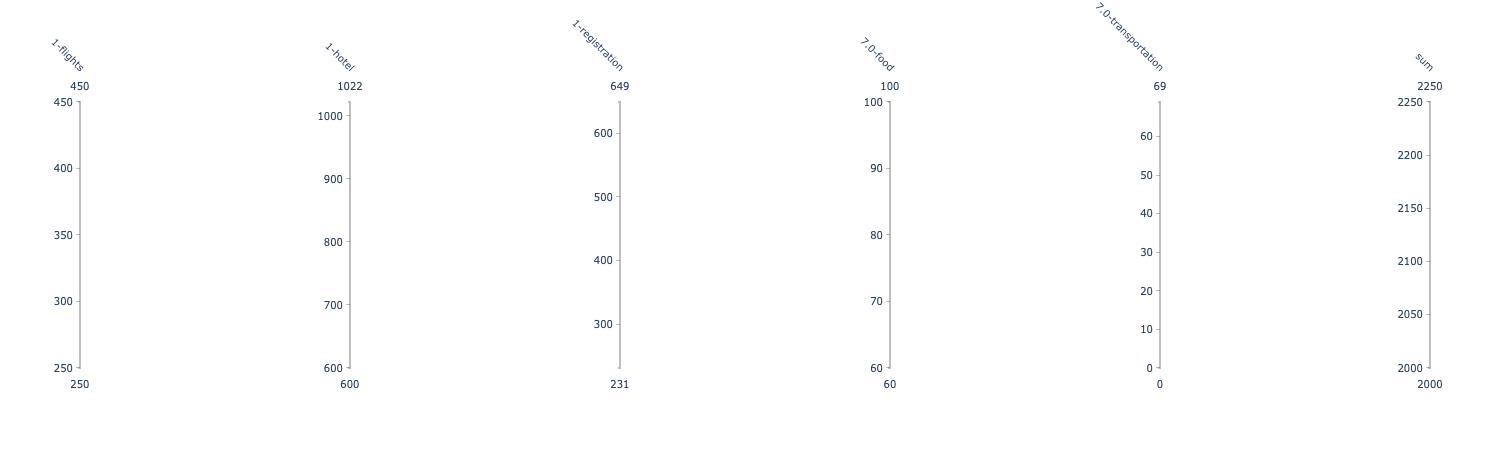

In [38]:
fig = go.Figure(data=
    go.Parcoords(
        line_color='rgba(0,0,255,1)',
        labelangle=45,
        dimensions = [
            dict(range = [round(df[s].min()),round(df[s].max())],
                 label = s, 
                 values = df[s].values) for s in list(df.columns)]
    ),
)
fig.show()